## Solving n-queens with a modern C(S)P solver

This notebook was created for the CSP lecture of the 'Intro to AI' lecture by Tias Guns, based on the famous Russell and Norvig book.

Somebody had written on a slide that CSP solving with backtracking search, arc consistency and a good variable ordering makes solving n-queens for N=1000 'feasible'.

So, this notebook checks how 'feasible' n-queens for different N is for a modern CP solver like or-tools CP-SAT.
(technical note: we first tuned the hyper parameters on N=100 so that the solver is performing at its best)

In [1]:
"""
N-queens problem in CPMpy

CSPlib prob054

Problem description from the numberjack example:
The N-Queens problem is the problem of placing N queens on an N x N chess
board such that no two queens are attacking each other. A queen is attacking
another if it they are on the same row, same column, or same diagonal.
"""

# load the libraries
import numpy as np
from cpmpy import *

def nqueens(N):
    # Variables (one per row)
    queens = intvar(1,N, shape=N, name="queens")

    # Constraints on columns and left/right diagonal
    m = Model([
        AllDifferent(queens),
        AllDifferent([queens[i] + i for i in range(N)]),
        AllDifferent([queens[i] - i for i in range(N)]),
    ])
    
    return (m, queens)

def nqueens_solve(N):
    (m, queens) = nqueens(N)
    
    # tuned params: {'cp_model_probing_level': 0, 'linearization_level': 0, 'symmetry_level': 0}
    s = SolverLookup.get("ortools", m)
    s.solve(cp_model_probing_level=0, linearization_level=0, symmetry_level=0)
    print(s.status())
    return queens.value()
    
N = 4
Qs = nqueens_solve(N)

ExitStatus.OPTIMAL (0.005953405 seconds)


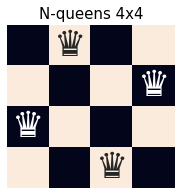

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib/seaborn graphical visualisation
def visu_queens(queenlist, figsize=(12,12)):
    N = len(queenlist)
    
    # checkerboard background
    bg = np.zeros((N,N))
    for (i,j),v in np.ndenumerate(bg):
        bg[i,j] = (i+j)%2
    
    # queen labels
    labels = np.zeros((N,N), dtype=str)
    for i,j in enumerate(queenlist):
        labels[i,j-1] = '♛'
    
    # the figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.set(font_scale=3)
    sns.heatmap(bg, annot=labels,
                fmt='s', cbar=False, xticklabels=False, yticklabels=False)
    plt.title(f"N-queens {N}x{N}", fontsize=15)
    plt.show()


visu_queens(Qs, figsize=(3,3))

Solving 8 queens...
ExitStatus.OPTIMAL (0.002483522 seconds)


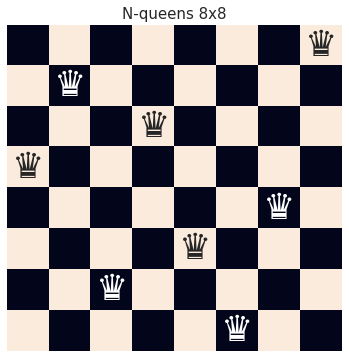


Solving 25 queens...
ExitStatus.OPTIMAL (0.012166811000000001 seconds)


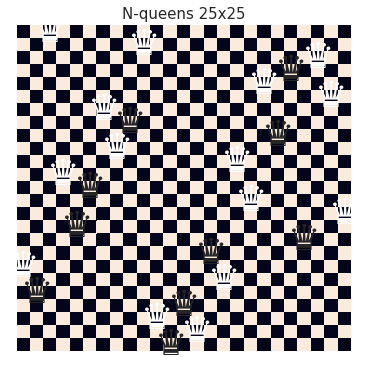


Solving 100 queens...
ExitStatus.OPTIMAL (0.165809124 seconds)


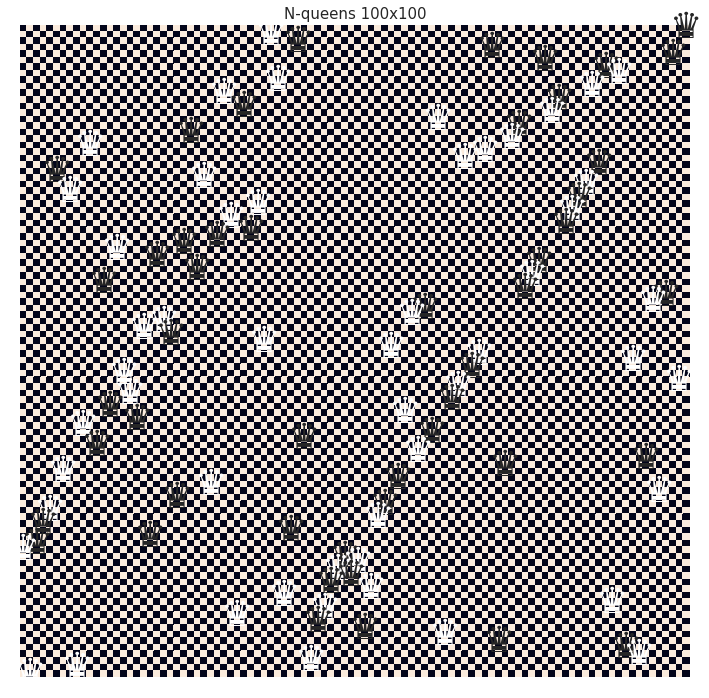


Solving 200 queens...
ExitStatus.OPTIMAL (0.811660621 seconds)


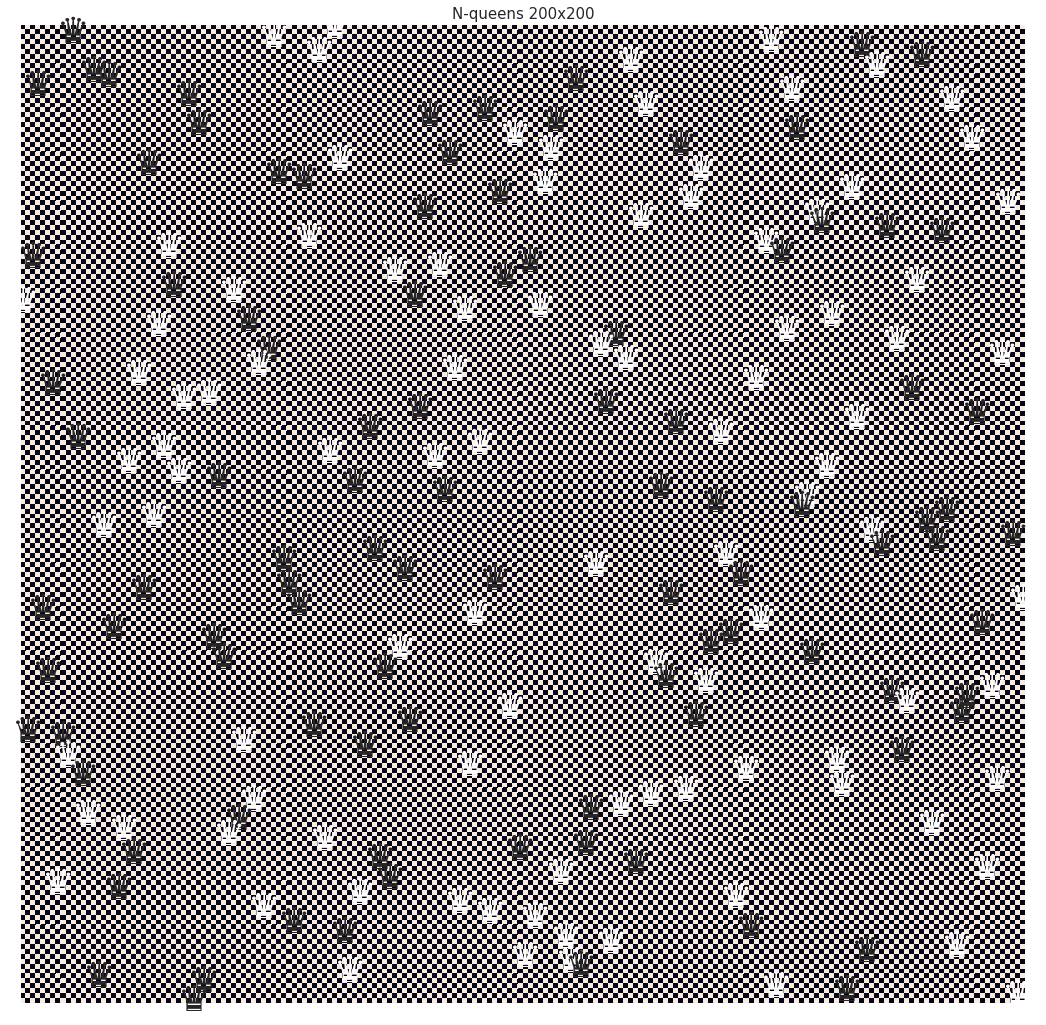


Solving 500 queens...
ExitStatus.OPTIMAL (5.676120190000001 seconds)



In [3]:
for N in [8,25,100,200,500]: #,1000]: run 1000 at your own risk
    print("Solving",N,"queens...")
    Qs = nqueens_solve(N)
    if N <= 50:
        visu_queens(Qs, figsize=(6,6))
    elif N <= 100:
        visu_queens(Qs, figsize=(12,12))
    elif N <= 400:
        visu_queens(Qs, figsize=(18,18))
    print() # empty line

In [4]:
# param tune to find the fastest solver parameters
(m, x) = nqueens(100)

m.solve()
base_runtime = m.status().runtime
print("Runtime with default params", base_runtime)

from cpmpy.solvers import CPM_ortools, param_combinations

all_params = {'cp_model_probing_level': [0,1,2,3],
              'linearization_level': [0,1,2],
              'symmetry_level': [0,1,2]}

configs = [] # (runtime, param)
for params in param_combinations(all_params):
    s = CPM_ortools(m)
    print("Running", params, end='\r')
    s.solve(time_limit=base_runtime*1.05, **params)
    configs.append( (s.status().runtime, params) )
    base_runtime = min([base_runtime, s.status().runtime])

best = sorted(configs)[0]
print("\nFastest in", round(best[0],4), "seconds, config:", best[1])

Runtime with default params 0.537496324
Running {'cp_model_probing_level': 3, 'linearization_level': 2, 'symmetry_level': 2}
Fastest in 0.1527 seconds, config: {'cp_model_probing_level': 0, 'linearization_level': 2, 'symmetry_level': 0}


In [ ]:
# use best parameter to solve N=1000
chosen_param = best[1]
(m, x) = nqueens(1000)
s = CPM_ortools(m)
print("Running", chosen_param)
s.solve(**chosen_param)
print(s.status())

Running {'cp_model_probing_level': 0, 'linearization_level': 2, 'symmetry_level': 0} 

ExitStatus.OPTIMAL (75.13570860200001 seconds)
